In [60]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os

In [76]:
from IPython.display import display, HTML

In [127]:
#Event dataframe anlegen zur späteren Auswertung der An/Abschaltevents
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index' ,'Ladevorgang', 'Status', 'Ladeleistung','minuten_index_Abschaltung','timestamp_abschalt'])

#iteration über alle Phasen
for Phase in range (1,4):
    #Einlesen der aktuellen .csv einer Phase
    P_Phase = pd.read_csv('power_today_minute_'+str(Phase)+'.csv', names = ['timestamp','P'])
    Phase_mit_delta = P_Phase
    Phase_mit_delta['P_delta'] = 0
    Leerlaufleistung_Phase = P_Phase[0:100]['P'].mean()
    
    #Iteration über alle Werte (Minuten) dieser Phase
    for row in range(1,len(P_Phase)):
        # daten import
        Timestamp = P_Phase.iloc[row]['timestamp']
        minuten_index = row
        P_new = P_Phase.iloc[row]['P']
        P_old = P_Phase.iloc[row-1]['P']
        P_delta = P_new-P_old
        Phase_mit_delta.loc[row, 'P_delta'] = P_delta
        Phase_mit_delta.to_csv('test' + str(Phase) + '.csv')

        ### Einschaltvorgang dedektieren ###
        # ist delta P relevant
        if(P_delta > 400.0):
            # Prüfen ob Ladenvorgang beginnt/beendet
            #Wenn delta P positiv ---> event kreieren um später zu checken ob es ein Einschaltvorgang war
            Event_df.loc[len(Event_df)]= [Timestamp, Phase, minuten_index, 'ein', 'not checked', 0,0,0]

        #Check events: Überprüfen ob vorher eingetragenes event wirklich ein Einschaltvorgang ist
        Events = len(Event_df)
        row_event = 0
        while row_event < Events:
            #condition to check event
            minuten_index_event = Event_df.iloc[row_event]['minuten_index']
            #Check auf Einschaltvorgang
            if ((minuten_index_event+3 == minuten_index) & 
                (Event_df.iloc[row_event]['Ladevorgang'] == 'ein') &
                (Event_df.iloc[row_event]['Phase'] == Phase)):
                Ladeleistung = P_Phase.iloc[minuten_index_event+3]['P'] - P_Phase.iloc[minuten_index_event-3]['P'] 
                sum_delta_P = Phase_mit_delta[minuten_index_event:minuten_index_event+3]['P_delta'].sum()
                deviation = abs(Ladeleistung-sum_delta_P)/Ladeleistung 
                #print('Minute' + str(row))
                #print(Event_df)
                #print('Ladeleistung: ' + str(Ladeleistung))
                #print('sum_delta_P: ' + str(sum_delta_P))
                #print('deviation' + str(deviation))
                if ((deviation > 0.15) | (Ladeleistung < 1500)):
                    Event_df = Event_df.drop(row_event)
                    Event_df = Event_df.reset_index(drop=True)
                else:
                    Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', Ladeleistung]
            Events = len(Event_df)
            row_event += 1
        ### Ausschaltvorgang dedektieren ###
        #Checken ob aktuelle Leistung das Ende eines Einschaltvorgangs impliziert        
        if (('ein' in Event_df['Ladevorgang'].unique()) &
           ('checked' in Event_df['Status'].unique())):
            # create df with charging status on
            only_load_event_df = Event_df[(Event_df['Ladevorgang'] == 'ein') & (Event_df['minuten_index'] < minuten_index)]
            #Soll Leistung = Leistung die auf der Phase anliegen sollte, wenn alle zuvor ladenden Autos noch an der Phase hängen würden
            Soll_Leistung = Leerlaufleistung_Phase + Event_df[(Event_df['Ladevorgang']=='ein') & 
                                                              (Event_df['minuten_index'] <= minuten_index) & 
                                                              (Event_df['minuten_index_Abschaltung'] == 0) & 
                                                              (Event_df['Phase'] == Phase)]['Ladeleistung'].sum()
            #Aktuelle Leistung (neuer Messwert)
            Ist_Leistung = P_new 
            #Residuale Leistung 
            P_residual = Soll_Leistung - Ist_Leistung
            #Überprüfen ob fehlende Leistung (P_residual) zu einem zuvor ladenden Auto passt
            only_load_event_df['deviation_P'] = only_load_event_df['Ladeleistung'].apply(lambda ladeleistung_auto: abs(ladeleistung_auto-P_residual)/
                                                                                         ladeleistung_auto)
            if ((only_load_event_df['deviation_P'] < 0.03).any()):
                # sort load events by size
                # und nehme das erste Event, was der aktuellen leistung am nächsten ist
                charg_off_ev_index = only_load_event_df['deviation_P'].sort_values().index[0]
                Event_df.loc[charg_off_ev_index,['minuten_index_Abschaltung']] = minuten_index
                Event_df.loc[charg_off_ev_index,['timestamp_abschalt']] = Timestamp
                Event_df.loc[charg_off_ev_index, ['Ladevorgang']] = 'aus'

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
row_event

11

In [106]:
len(Event_df)

11

## Alter Code     
        for charge in range(0, len(Event_df)):
            if ((Event_df.iloc[charge]['Ladevorgang'] == 'ein') & 
                (Event_df.iloc[charge]['minuten_index_Abschaltung'] == 0)):
                Ladeleistung_auto = Event_df.iloc[charge]['Ladeleistung']
                deviation_P = (abs(Ladeleistung_auto-P_residual)/Ladeleistung_auto)
                if ((deviation_P < 0.02)):
                        Event_df.loc[charge,['minuten_index_Abschaltung']] = minuten_index
                        Event_df.loc[charge,['timestamp_abschalt']] = Timestamp
                        einschaltvorgang_gefunden = 1
                        Event_df.loc[charge, ['Ladevorgang']] = 'aus'
                        #print(deviation_P)
                        #print('tada')

In [128]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.505798e+09,1,427,aus,checked,3571,528,1.5058e+09
1,1.505800e+09,1,461,aus,checked,3583,551,1.50581e+09
2,1.505824e+09,1,873,aus,checked,3606,939,1.50583e+09
3,1.505831e+09,1,988,aus,checked,3836,1015,1.50583e+09
4,1.505793e+09,2,353,aus,checked,3441,467,1.5058e+09
5,1.505807e+09,2,578,aus,checked,3535,816,1.50582e+09
6,1.505815e+09,2,720,aus,checked,3587,836,1.50582e+09
7,1.505821e+09,2,822,ein,checked,3459,0,0
8,1.505827e+09,2,920,aus,checked,3482,1015,1.50583e+09
9,1.505831e+09,2,988,aus,checked,3832,1015,1.50583e+09


In [129]:
Event_df = Event_df.sort_values('timestamp')
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
4,1.505793e+09,2,353,aus,checked,3441,467,1.5058e+09
0,1.505798e+09,1,427,aus,checked,3571,528,1.5058e+09
1,1.505800e+09,1,461,aus,checked,3583,551,1.50581e+09
5,1.505807e+09,2,578,aus,checked,3535,816,1.50582e+09
10,1.505810e+09,3,637,aus,checked,3590,933,1.50583e+09
6,1.505815e+09,2,720,aus,checked,3587,836,1.50582e+09
7,1.505821e+09,2,822,ein,checked,3459,0,0
2,1.505824e+09,1,873,aus,checked,3606,939,1.50583e+09
8,1.505827e+09,2,920,aus,checked,3482,1015,1.50583e+09
3,1.505831e+09,1,988,aus,checked,3836,1015,1.50583e+09


In [130]:
# Zusammenfassen von mehrphasigen Ladevorängen
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])


for events in range(0,len(Event_df)):
    timestamp = Event_df.iloc[events]['timestamp']
    timestamp_abschaltung = Event_df.iloc[events]['timestamp_abschalt']
    Phase = []
    Ladeleistung = []
    same_events = Event_df.loc[Event_df['timestamp'] == Event_df.iloc[events]['timestamp']]
    event_count = len(same_events)
    for a in range (0,event_count):
        Phase.append(same_events.iloc[a]['Phase'])
        Ladeleistung.append(str(same_events.iloc[a]['Phase'])+': '+str(same_events.iloc[a]['Ladeleistung']))
    if (len(ladevorgang_df.loc[ladevorgang_df['timestamp_start'] == timestamp]) !=1):
        ladevorgang_df.loc[len(ladevorgang_df)]= [timestamp, Phase, Ladeleistung, timestamp_abschaltung]
ladevorgang_df

,timestamp_start,Phasen,Durchschnittliche Ladeleistung,Ladevorgang_ende
0,1.505793e+09,[2],[2: 3441.0],1.505800e+09
1,1.505798e+09,[1],[1: 3571.0],1.505804e+09
2,1.505800e+09,[1],[1: 3583.0],1.505805e+09
3,1.505807e+09,[2],[2: 3535.0],1.505821e+09
4,1.505810e+09,[3],[3: 3590.0],1.505828e+09
5,1.505815e+09,[2],[2: 3587.0],1.505822e+09
6,1.505821e+09,[2],[2: 3459.0],0.000000e+00
7,1.505824e+09,[1],[1: 3606.0],1.505828e+09
8,1.505827e+09,[2],[2: 3482.0],1.505833e+09
9,1.505831e+09,"[1, 2, 3]","[1: 3836.0, 2: 3832.0, 3: 3852.0]",1.505833e+09


In [110]:
Phase_P.iloc[1]['P']

125.0

<IPython.core.display.Javascript object>


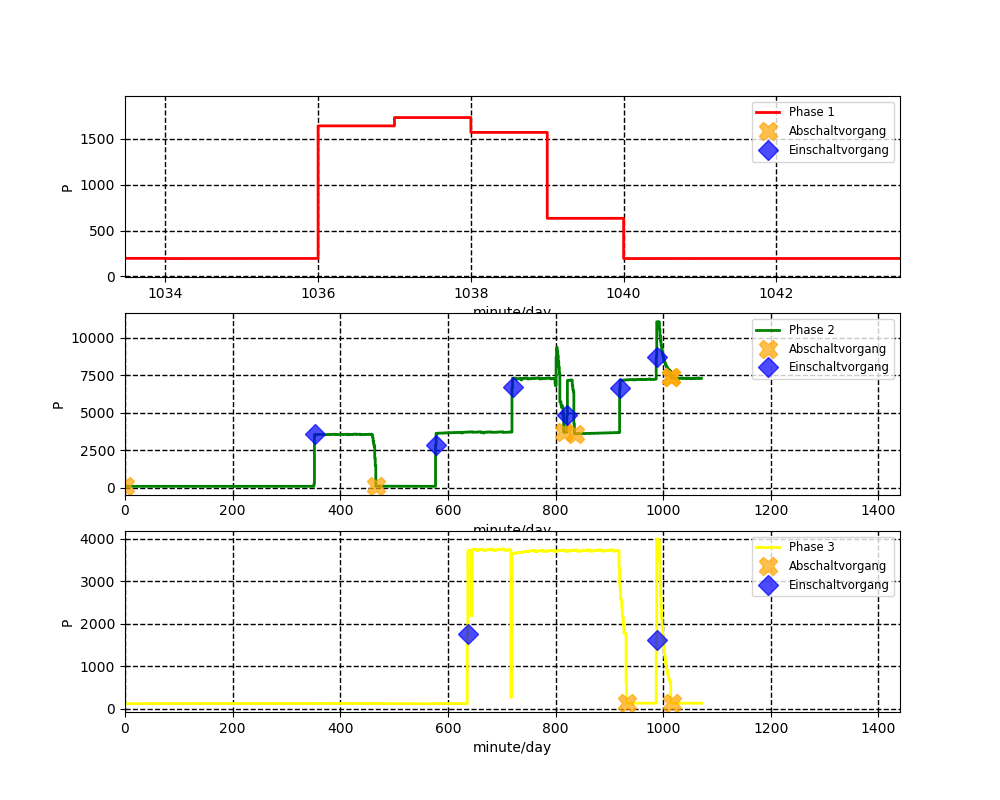

In [131]:
#Plotten aller phasen mit ein und ausschaltvorgang
colors_phase = ['red','green','yellow']
plt.figure(figsize=(10,8))
for Phase in range (1,4):
    Phase_P = pd.read_csv('power_today_minute_'+str(Phase)+'.csv', names = ['timestamp','P'])
    plt.subplot(310+Phase)
    plt.step(Phase_P.index,Phase_P['P'], color=colors_phase[Phase-1], linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung']]['P'], "X",color="orange", markersize=13,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index']]['P'], "D", color="blue", markersize=10,alpha=.7, label='Einschaltvorgang')
    plt.legend(loc='upper right', frameon=True, fontsize = 'small')
    plt.grid(color='k', linestyle='--', linewidth=1)
    plt.xlim([0,1440])
    plt.ylabel('P')
    plt.xlabel('minute/day')

,timestamp,P
0,1.505340e+09,126
1,1.505340e+09,127
2,1.505340e+09,127
3,1.505340e+09,127
4,1.505340e+09,127
5,1.505340e+09,127
6,1.505340e+09,127
7,1.505340e+09,127
8,1.505340e+09,127
9,1.505341e+09,127
